## Random Forest "Reloaded"

In [122]:
"""
A more advanced version of the random forest predictor, with
- advanced feature engineering
- grid search
- cross validation

@author: timo, team8, 8team
"""

# utilities

import numpy as np
import pandas as pd
import titanic_helpers as th

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ml
from sklearn.ensemble import RandomForestClassifier

## Part 1: Data Preparation

In [108]:
train_df = pd.read_csv('../data/titanic3_train.csv',  delimiter=';')
test_df = pd.read_csv('../data/titanic3_test.csv',  delimiter=';')


Have a look at the data:

In [109]:
test_df.columns.values

array(['id', 'pclass', 'name', 'surname', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype=object)

In [110]:
missing_val_count_by_column = (train_df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > -1])

id             0
pclass         0
survived       0
name           0
surname        0
sex            0
age          211
sibsp          0
parch          0
ticket         0
fare           1
cabin        817
embarked       1
boat         661
body         951
home.dest    456
dtype: int64


In [111]:
print(train_df.columns.values)

print(train_df.sample(3))

train_df.info()

['id' 'pclass' 'survived' 'name' 'surname' 'sex' 'age' 'sibsp' 'parch'
 'ticket' 'fare' 'cabin' 'embarked' 'boat' 'body' 'home.dest']
      id  pclass  survived       name  \
484  606       3         1   Abelseth   
177  222       1         0      Ostby   
506  633       3         0  Andersson   

                                            surname     sex   age  sibsp  \
484                             Mr. Olaus Jorgensen    male  25.0      0   
177                         Mr. Engelhart Cornelius    male  65.0      0   
506  Mrs. Anders Johan (Alfrida Konstantia Brogren)  female  39.0      1   

     parch  ticket     fare  cabin embarked boat   body            home.dest  
484      0  348122   7.6500  F G63        S    A    NaN   Perkins County, SD  
177      1  113509  61.9792    B30        C  NaN  234.0       Providence, RI  
506      5  347082  31.2750    NaN        S  NaN    NaN  Sweden Winnipeg, MN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data c

### Variable preparation

Drop some columns.

In [112]:
# save passenger ids for submission
test_ids = test_df['id']

def drop_columns(df):
    return df.drop(['id', 'ticket', 'embarked', 'home.dest', 'boat', 'body'], axis=1)

train_df = drop_columns(train_df)
test_df = drop_columns(test_df)

In [113]:
train_df.info()
missing_val_count_by_column = (train_df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > -1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 10 columns):
pclass      1048 non-null int64
survived    1048 non-null int64
name        1048 non-null object
surname     1048 non-null object
sex         1048 non-null object
age         837 non-null float64
sibsp       1048 non-null int64
parch       1048 non-null int64
fare        1047 non-null float64
cabin       231 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 82.0+ KB
pclass        0
survived      0
name          0
surname       0
sex           0
age         211
sibsp         0
parch         0
fare          1
cabin       817
dtype: int64


#### Age
Add age buckets and fill up unknown ages with most common age.

In [114]:
def simplify_ages(df):
    df.age = df.age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.age, bins, labels=group_names)
    df.age = categories
    return df
train_df = simplify_ages(train_df)
train_df.info()

test_df = simplify_ages(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 10 columns):
pclass      1048 non-null int64
survived    1048 non-null int64
name        1048 non-null object
surname     1048 non-null object
sex         1048 non-null object
age         1048 non-null category
sibsp       1048 non-null int64
parch       1048 non-null int64
fare        1047 non-null float64
cabin       231 non-null object
dtypes: category(1), float64(1), int64(4), object(4)
memory usage: 75.2+ KB


In [115]:
train_df.head()

,pclass,survived,name,surname,sex,age,sibsp,parch,fare,cabin
0,1,1,Allen,Miss. Elisabeth Walton,female,Young Adult,0,0,211.3375,B5
1,1,1,Allison,Master. Hudson Trevor,male,Baby,1,2,151.5500,C22 C26
2,1,0,Allison,Miss. Helen Loraine,female,Baby,1,2,151.5500,C22 C26
3,1,0,Allison,Mr. Hudson Joshua Creighton,male,Young Adult,1,2,151.5500,C22 C26
4,1,1,Anderson,Mr. Harry,male,Adult,0,0,26.5500,E12


In [116]:
# Replace 'Unknown' with most common age group
ages = train_df.groupby("age").size().reset_index(name='N')
print(ages)
most_common_age = ages.age[ages.N == max(ages.N)]
# extract single value, else the below lambda function does not work
most_common_age = most_common_age.values[0]
# most common age is Adult
train_df.age = train_df.age.apply(lambda age: most_common_age if age == 'Unknown' else age)

test_df.age = test_df.age.apply(lambda age: most_common_age if age == 'Unknown' else age)

           age    N
0      Unknown  211
1         Baby   40
2        Child   34
3     Teenager   81
4      Student  204
5  Young Adult  216
6        Adult  234
7       Senior   28


/home/tgrossen/.anaconda3/envs/cas-infe-18-titanic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


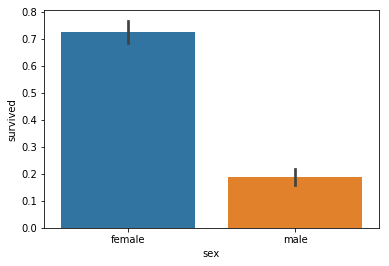

In [117]:
sns.barplot(x='sex', y='survived',data=train_df)

/home/tgrossen/.anaconda3/envs/cas-infe-18-titanic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


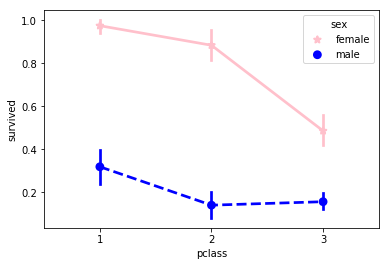

In [118]:
sns.pointplot(x='pclass', y='survived', hue='sex', data=train_df,
              palette={'male': 'blue', 'female': 'pink'},
              markers=['*', 'o'], linestyles=['-', '--']);

### Feature Engineering

In [119]:
# for the moment, drop everything except sex, age and pclass
train_df = train_df.loc[:, ['survived', 'sex', 'age', 'pclass']]
train_df.info()
missing_val_count_by_column = (train_df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > -1])

test_df = test_df.loc[:, ['survived', 'sex', 'age', 'pclass']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 4 columns):
survived    1048 non-null int64
sex         1048 non-null object
age         1048 non-null object
pclass      1048 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.8+ KB
survived    0
sex         0
age         0
pclass      0
dtype: int64


/home/tgrossen/.anaconda3/envs/cas-infe-18-titanic/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [120]:
# enable one-hot-encoding
train_df = pd.get_dummies(train_df)
train_df.info()
train_df.head()

test_df = pd.get_dummies(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 11 columns):
survived           1048 non-null int64
pclass             1048 non-null int64
sex_female         1048 non-null uint8
sex_male           1048 non-null uint8
age_Adult          1048 non-null uint8
age_Baby           1048 non-null uint8
age_Child          1048 non-null uint8
age_Senior         1048 non-null uint8
age_Student        1048 non-null uint8
age_Teenager       1048 non-null uint8
age_Young Adult    1048 non-null uint8
dtypes: int64(2), uint8(9)
memory usage: 25.7 KB


### Training

In [123]:
X_train = train_df.drop(['survived'], axis=1)
y_train = train_df['survived']

X_test = test_df.drop(['survived'], axis=1)
y_test = test_df['survived']

forest = RandomForestClassifier(n_estimators=100)

forest = forest.fit(X_train, y_train)

train_df.info()
test_df.info()
# predict output of test_df
output = forest.predict(X_test).astype(np.float)
output



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 11 columns):
survived           1048 non-null int64
pclass             1048 non-null int64
sex_female         1048 non-null uint8
sex_male           1048 non-null uint8
age_Adult          1048 non-null uint8
age_Baby           1048 non-null uint8
age_Child          1048 non-null uint8
age_Senior         1048 non-null uint8
age_Student        1048 non-null uint8
age_Teenager       1048 non-null uint8
age_Young Adult    1048 non-null uint8
dtypes: int64(2), uint8(9)
memory usage: 25.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 11 columns):
survived           0 non-null float64
pclass             261 non-null int64
sex_female         261 non-null uint8
sex_male           261 non-null uint8
age_Adult          261 non-null uint8
age_Baby           261 non-null uint8
age_Child          261 non-null uint8
age_Senior         261 non-null uint8
age_St

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:

# Create DataFrame for outputfile
df = pd.DataFrame(columns=['id', 'survived'])
df['id'] = test_ids
df['survived'] = output.astype(int)

# Write the data into a file
th.write_csv(df=df)

# automagically submit to server
th.submit_answer(df, custom_name='random_forest_reloaded')
